#### Columnas Originales

* ITEM_ID: id unívoco de cada item publicado. (Ofuscado)
* SHP_WEIGHT: peso del paquete informado por el correo.
* SHP_LENGTH: largo del paquete informado por el correo.
* SHP_WIDTH: ancho del paquete informado por el correo.
* SHP_HEIGHT: altura del paquete informado por el correo.
* ATTRIBUTES: atributos como marca y modelo, entre otros, en formato json-lines
* CATALOG_PRODUCT_ID: id del catálogo (ofuscado).
* CONDITION: condición de venta (nuevo o usado).
* DOMAIN_ID: id de la categoría a la que pertenece la publicación.
* PRICE: precio en reales.
* SELLER_ID: id del vendedor (ofuscado).
* STATUS: estado de la publicación (activa, cerrada, pausada, etc.)
* TITLE: título de la publicación.


#### Columnas Actuales

* ITEM_ID
* SHP_WEIGHT
* SHP_LENGTH
* SHP_WIDTH
* SHP_HEIGHT
* RV_PRICE, precio revisado
* STATUS
* TITLE
* LEN_ATR: cantidad de atributos
* DT_CAT_PROD: ID Catalogo del Producto-Revisado
* DT_CONDITION: Condición de Venta -Revisado
* DT_DOMAIN: Categoría de la Publicación -Revisado
* DT_SELLER: ID Vendedor -Revisado
* DT_BRAND: Marca del Producto -Revisado
* DT_MODEL: Modelo del Producto -Revisado
* SCORE: Peso ponderado del Título de la publicación sobre si excede la dimensión máxima
* EXCEDIDO: Si el producto excede el límite del correo


In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from sklearn import preprocessing

import random
random.seed(0)

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
DATASET = 'meli_dataset_c.csv'

In [3]:
#Recupero Dataset
df_raw = pd.read_csv(DATASET, low_memory=False)
df_base = df_raw.copy()

In [4]:
print(df_base.shape)
print(df_base.dtypes)
display(df_base.sample(5))

(296291, 17)
ITEM_ID          object
SHP_WEIGHT      float64
SHP_LENGTH      float64
SHP_WIDTH       float64
SHP_HEIGHT      float64
RV_PRICE        float64
STATUS           object
TITLE            object
LEN_ATR           int64
DT_CAT_PROD      object
DT_CONDITION     object
DT_DOMAIN        object
DT_SELLER        object
DT_BRAND         object
DT_MODEL         object
SCORE           float64
EXCEDIDO          int64
dtype: object


,ITEM_ID,SHP_WEIGHT,SHP_LENGTH,SHP_WIDTH,SHP_HEIGHT,RV_PRICE,STATUS,TITLE,LEN_ATR,DT_CAT_PROD,DT_CONDITION,DT_DOMAIN,DT_SELLER,DT_BRAND,DT_MODEL,SCORE,EXCEDIDO
150759,MOBJCHB1B5,4380.0,58.0,36.0,16.0,214.99,paused,Jogo De Panela Aluminio Rev. Cerâmica Frete Grais,16,H53U1H7Q5G,new,MLB-KITCHEN_POTS,OTROS,CLINK,OTROS,0.003833,0
107576,FH98XCG3HB,9880.0,78.0,18.0,4.0,64.90,active,Estante Expositor 5 Prateleiras 100 Esmaltes 6...,12,H53U1H7Q5G,new,OTROS,TYAQEEJ32G,OTROS,OTROS,0.999619,1
184264,TW4WBVVKXT,158.0,16.0,16.0,5.0,517.00,active,45 Mochilas Mochilinhas Personalizadas,9,H53U1H7Q5G,new,MLB-COMMERCIAL_AND_EVENT_BAGS,OTROS,OTROS,OTROS,0.097336,0
259210,JT3PMCOZVW,70.0,16.0,11.0,10.0,59.90,closed,Chave Canivete Mitsubishi Triton 2 Botões,1,H53U1H7Q5G,new,MLB-VEHICLE_PARTS,OTROS,SIN_DATOS,SIN_DATOS,0.006148,0
28789,CMCPRJ4YUX,990.0,39.0,29.0,18.0,89.00,paused,Bolsa Case P/ Câmera Fotográfica Dslr Nikon Ca...,18,OTROS,new,MLB-CAMERA_BAGS,OTROS,OTROS,OTROS,0.078064,0


1. Definimos las columnas a utilizar para los modelos:

Descartados:
* ITEM_ID,  es la publicación y consideramos que 
* SHP_WEIGHT, no se conoce, es info del correo 
* SHP_LENGTH, idem
* SHP_WIDTH, idem
* SHP_HEIGHT, idem
* TITLE
* SCORE, lo exluimos para determinar que impacto tiene
* EXCEDIDO: creamos el atributo NO_MAQUINABLE como dato lógico

Consideramos:
* RV_PRICE
* LEN_ATR cantidad de atributos
* STATUS
* DT_CAT_PROD: ID Catalogo del Producto-Revisado
* DT_CONDITION: Condición de Venta -Revisado
* DT_DOMAIN: Categoría de la Publicación -Revisado
* DT_SELLER: ID Vendedor -Revisado
* DT_BRAND: Marca del Producto -Revisado
* DT_MODEL: Modelo del Producto -Revisado
* NO_MAQUINABLE: 

In [5]:
#Pasamos la variable EXCEDIDO a lógica
df_base['NO_MAQUINABLE']=(df_base.EXCEDIDO == 1)

In [6]:
df_base[ ['NO_MAQUINABLE','EXCEDIDO'] ].sample(5)

,NO_MAQUINABLE,EXCEDIDO
173881,False,0
107031,False,0
59101,False,0
226472,False,0
70876,False,0


In [7]:
col_categorias=['STATUS','DT_CAT_PROD','DT_CONDITION','DT_DOMAIN','DT_SELLER','DT_BRAND','DT_MODEL']
col_continuas=['RV_PRICE','LEN_ATR']
col_x = col_continuas + col_categorias 
col_y = ['NO_MAQUINABLE']

In [8]:
df_modelo=df_base[col_x + col_y]

In [9]:
print(df_modelo.shape)
print(df_modelo.dtypes)

(296291, 10)
RV_PRICE         float64
LEN_ATR            int64
STATUS            object
DT_CAT_PROD       object
DT_CONDITION      object
DT_DOMAIN         object
DT_SELLER         object
DT_BRAND          object
DT_MODEL          object
NO_MAQUINABLE       bool
dtype: object


2. Armamos conjuntos de entreamiento y validación

In [10]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler 

In [11]:
sMM=MinMaxScaler()
Xcon = sMM.fit_transform(df_modelo[col_continuas])
Xcon = pd.DataFrame(Xcon, columns=col_continuas)

print(Xcon.shape)
display(df_modelo[col_continuas].head(5))
display(Xcon.head(5))
display(Xcon.describe())

(296291, 2)


,RV_PRICE,LEN_ATR
0,68.0,6
1,145.9,9
2,145.9,9
3,145.9,9
4,145.9,9


,RV_PRICE,LEN_ATR
0,0.002263,0.10
1,0.004860,0.15
2,0.004860,0.15
3,0.004860,0.15
4,0.004860,0.15


,RV_PRICE,LEN_ATR
count,296291.000000,296291.000000
mean,0.005810,0.131977
std,0.014117,0.094612
min,0.000000,0.000000
25%,0.001677,0.066667
50%,0.003437,0.133333
75%,0.005930,0.183333
max,1.000000,1.000000


In [12]:
Xcat = pd.get_dummies(df_modelo[col_categorias],columns=col_categorias, sparse=True)

#Junto Categóricas y Numéricas
X=pd.concat([Xcat, Xcon], axis=1)
y=df_modelo[col_y]

print(X.shape)
print(X.dtypes)

display(X.head(5))
display(y.head(5))

(296291, 4383)
STATUS_active          Sparse[uint8, 0]
STATUS_closed          Sparse[uint8, 0]
STATUS_inactive        Sparse[uint8, 0]
STATUS_paused          Sparse[uint8, 0]
STATUS_under_review    Sparse[uint8, 0]
                             ...       
DT_MODEL_XTREME        Sparse[uint8, 0]
DT_MODEL_X_PLAY        Sparse[uint8, 0]
DT_MODEL__             Sparse[uint8, 0]
RV_PRICE                        float64
LEN_ATR                         float64
Length: 4383, dtype: object


,STATUS_active,STATUS_closed,STATUS_inactive,STATUS_paused,STATUS_under_review,DT_CAT_PROD_B2BWER04UG,DT_CAT_PROD_B5O1R5Z1VR,DT_CAT_PROD_BF6NGKUMZ9,DT_CAT_PROD_BW4AU3M2JW,DT_CAT_PROD_CCDEBX4JCH,...,DT_MODEL_XBOX_360,DT_MODEL_XBOX_ONE,DT_MODEL_XBOX_ONE_S,DT_MODEL_XENON,DT_MODEL_XIAOMI,DT_MODEL_XTREME,DT_MODEL_X_PLAY,DT_MODEL__,RV_PRICE,LEN_ATR
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.002263,0.10
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.004860,0.15
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.004860,0.15
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.004860,0.15
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.004860,0.15


,NO_MAQUINABLE
0,False
1,False
2,False
3,False
4,False


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [14]:
#Separamos en train(80%) y test (20%) y entrenamos el modelo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [15]:
print('TRAIN')
print('X:', X_train.shape)
print('y:', y_train.shape)

print('TEST')
print('X:', X_test.shape)
print('y:', y_test.shape)

TRAIN
X: (237032, 4383)
y: (237032, 1)
TEST
X: (59259, 4383)
y: (59259, 1)


3. Probamos SGDClassifier con función de costo LOG

In [16]:
from sklearn.linear_model import SGDClassifier

In [18]:
modeloSDG = SGDClassifier(random_state=5, n_jobs=-1, loss='log', alpha=0.001, early_stopping=True)
modeloSDG.fit(X_train, y_train)

C:\Users\Marcelo\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SGDClassifier(alpha=0.001, average=False, class_weight=None,
              early_stopping=True, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=-1, penalty='l2', power_t=0.5,
              random_state=5, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [19]:
y_train_pred = modeloSDG.predict(X_train)
y_test_pred  = modeloSDG.predict(X_test)

In [20]:
print('Exactitud para TRAIN: %.4f' % accuracy_score(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))

print('Exactitud para TEST : %.4f' % accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

Exactitud para TRAIN: 0.9551


C:\Users\Marcelo\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Marcelo\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

       False       0.96      1.00      0.98    226390
        True       0.00      0.00      0.00     10642

    accuracy                           0.96    237032
   macro avg       0.48      0.50      0.49    237032
weighted avg       0.91      0.96      0.93    237032

Exactitud para TEST : 0.9550
              precision    recall  f1-score   support

       False       0.95      1.00      0.98     56590
        True       0.00      0.00      0.00      2669

    accuracy                           0.95     59259
   macro avg       0.48      0.50      0.49     59259
weighted avg       0.91      0.95      0.93     59259



C:\Users\Marcelo\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Marcelo\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Marcelo\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Marcelo\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, wa

In [21]:
from ml.visualization import plot_confusion_matrix

In [22]:
confusion_matrix(y_train, y_train_pred)

array([[226390,      0],
       [ 10642,      0]], dtype=int64)

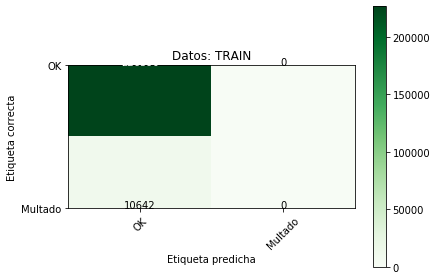

In [23]:
plot_confusion_matrix(confusion_matrix(y_train, y_train_pred), classes=['OK','Multado'], title="Datos: TRAIN", cmap=plt.cm.Greens)

In [24]:
confusion_matrix(y_test, y_test_pred)

array([[56590,     0],
       [ 2669,     0]], dtype=int64)

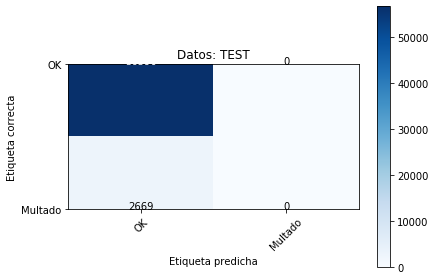

In [25]:
plot_confusion_matrix(confusion_matrix(y_test, y_test_pred), classes=['OK','Multado'], title="Datos: TEST")

4. Volvemos a probamos SGDClassifier con valores por defecto, ya que la ejecución anterior predecía todo como OK.

In [26]:
modeloSDG = SGDClassifier(random_state=5, n_jobs=-1)
modeloSDG.fit(X_train, y_train)

C:\Users\Marcelo\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=-1, penalty='l2',
              power_t=0.5, random_state=5, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [27]:
y_train_pred = modeloSDG.predict(X_train)
y_test_pred  = modeloSDG.predict(X_test)

In [28]:
print('Exactitud para TRAIN: %.4f' % accuracy_score(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))

print('Exactitud para TEST : %.4f' % accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

Exactitud para TRAIN: 0.9614
              precision    recall  f1-score   support

       False       0.96      1.00      0.98    226390
        True       0.81      0.19      0.30     10642

    accuracy                           0.96    237032
   macro avg       0.89      0.59      0.64    237032
weighted avg       0.96      0.96      0.95    237032

Exactitud para TEST : 0.9610
              precision    recall  f1-score   support

       False       0.96      1.00      0.98     56590
        True       0.81      0.18      0.29      2669

    accuracy                           0.96     59259
   macro avg       0.88      0.59      0.64     59259
weighted avg       0.96      0.96      0.95     59259



In [29]:
confusion_matrix(y_train, y_train_pred)

array([[225924,    466],
       [  8672,   1970]], dtype=int64)

In [30]:
confusion_matrix(y_test, y_test_pred)

array([[56477,   113],
       [ 2197,   472]], dtype=int64)

4. Probamos RandomFores con parámetros por defecto

In [31]:
from sklearn.ensemble import RandomForestClassifier

In [32]:
modeloRFC = RandomForestClassifier(random_state=5)
modeloRFC.fit(X_train, y_train)

C:\Users\Marcelo\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=5, verbose=0,
                       warm_start=False)

In [33]:
y_train_pred = modeloRFC.predict(X_train)
y_test_pred  = modeloRFC.predict(X_test)

In [34]:
print('Exactitud para TRAIN: %.4f' % accuracy_score(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))

print('Exactitud para TEST : %.4f' % accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

Exactitud para TRAIN: 0.9912
              precision    recall  f1-score   support

       False       0.99      1.00      1.00    226390
        True       0.96      0.84      0.90     10642

    accuracy                           0.99    237032
   macro avg       0.97      0.92      0.95    237032
weighted avg       0.99      0.99      0.99    237032

Exactitud para TEST : 0.9642
              precision    recall  f1-score   support

       False       0.97      0.99      0.98     56590
        True       0.66      0.42      0.51      2669

    accuracy                           0.96     59259
   macro avg       0.82      0.70      0.75     59259
weighted avg       0.96      0.96      0.96     59259



In [35]:
confusion_matrix(y_train, y_train_pred)

array([[225986,    404],
       [  1685,   8957]], dtype=int64)

In [36]:
confusion_matrix(y_test, y_test_pred)

array([[56019,   571],
       [ 1551,  1118]], dtype=int64)

Consultamos principales atributos considerados en el análisis

In [37]:
atr_imp=pd.DataFrame(data=zip(X.columns, modeloRFC.feature_importances_), columns=['Atributo','Importancia'] )
atr_imp.sort_values(by='Importancia', ascending=False, inplace=True)
atr_imp.head(10)

,Atributo,Importancia
4381,RV_PRICE,0.306015
4382,LEN_ATR,0.093905
0,STATUS_active,0.012656
3,STATUS_paused,0.011974
2117,DT_SELLER_OTROS,0.011175
141,DT_DOMAIN_MLB-AUTOMOTIVE_DEFLECTORS,0.011137
3512,DT_BRAND_OTROS,0.009228
557,DT_DOMAIN_MLB-FISHING_RODS,0.009070
95,DT_DOMAIN_MLB-ACOUSTIC_GUITARS,0.007879
1037,DT_DOMAIN_MLB-STOOLS,0.007466
